In [1]:
# Import PyTorch and related libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split

# Import torchvision for datasets and transforms
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

# Import visualization and utility libraries
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import time

# Set device for computation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)


Using device: cuda


## 1. Create Simple Object Detection Dataset

Creating synthetic object detection dataset...
Training samples: 3500
Validation samples: 1000
Test samples: 500
Number of classes: 3
Classes: ['circle', 'rectangle', 'triangle']

Sample images from the dataset:


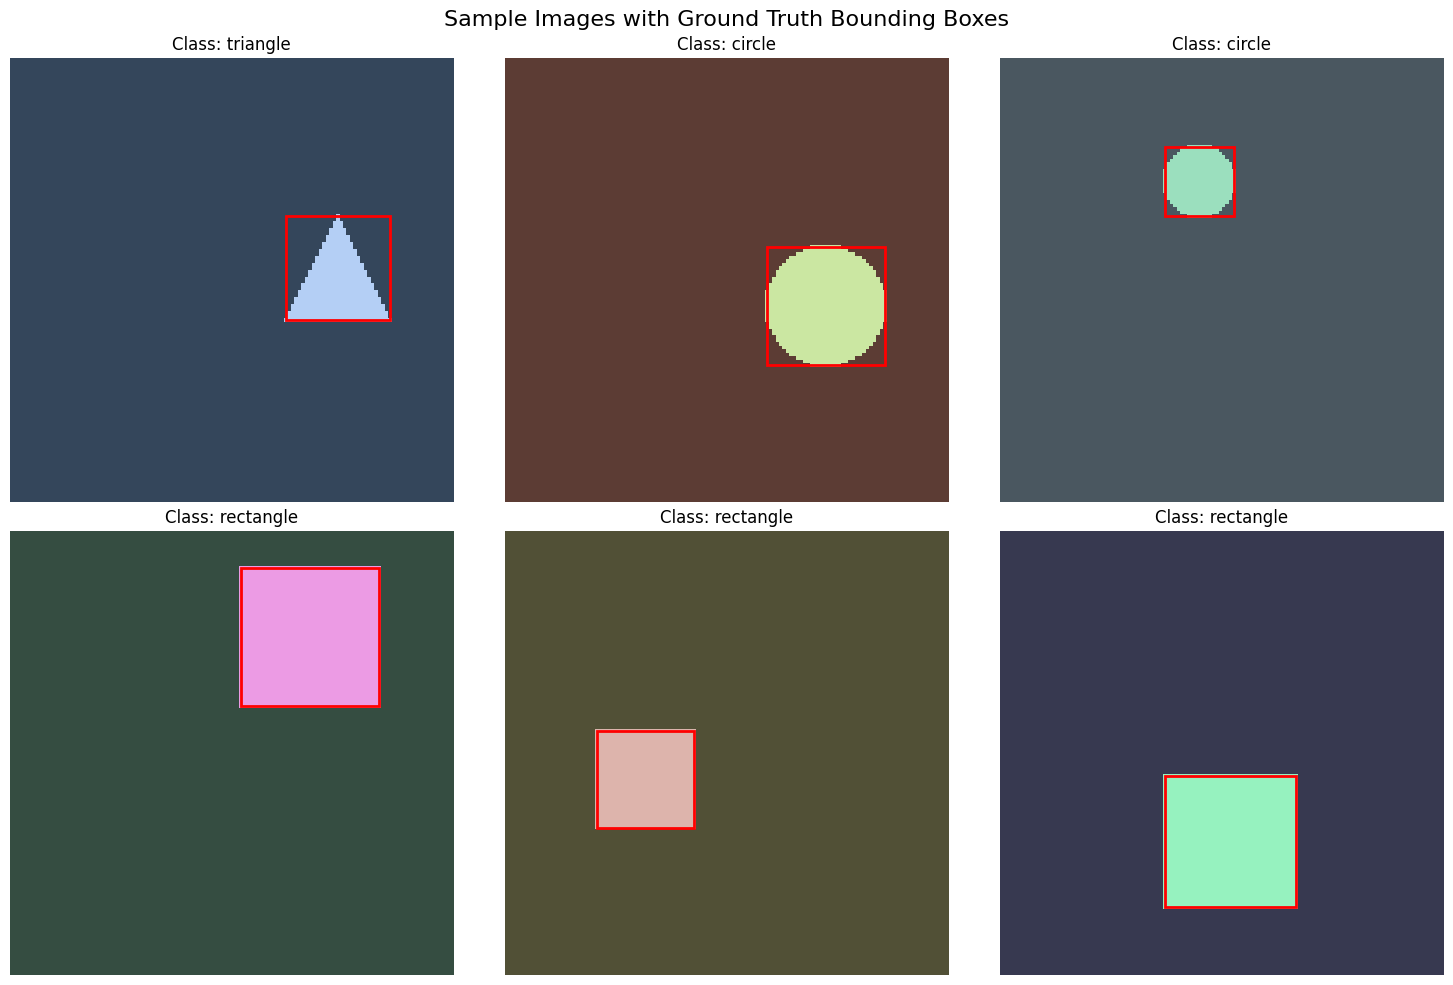

In [2]:
import random
from PIL import Image, ImageDraw

classes = ['circle', 'rectangle', 'triangle']
num_classes = len(classes)

# Dataset parameters
image_size = 128  # Larger than CIFAR-10 for better bbox visibility
dataset_size = 5000  # Smaller dataset for quick training
min_obj_size = 20
max_obj_size = 40

class SimpleObjectDetectionDataset(torch.utils.data.Dataset):
    def __init__(self, size, transform=None):
        self.size = size
        self.transform = transform
        self.data = []

        # Generate synthetic data
        for _ in range(size):
            # Create random background
            img = Image.new('RGB', (image_size, image_size),
                          color=(random.randint(50, 100), random.randint(50, 100), random.randint(50, 100)))
            draw = ImageDraw.Draw(img)

            # Random object parameters
            obj_class = random.randint(0, num_classes - 1)
            obj_size = random.randint(min_obj_size, max_obj_size)

            # Random position (ensure object fits in image)
            x = random.randint(obj_size//2, image_size - obj_size//2)
            y = random.randint(obj_size//2, image_size - obj_size//2)

            # Calculate bounding box (x1, y1, x2, y2)
            x1 = max(0, x - obj_size//2)
            y1 = max(0, y - obj_size//2)
            x2 = min(image_size, x + obj_size//2)
            y2 = min(image_size, y + obj_size//2)

            # Draw object
            color = (random.randint(150, 255), random.randint(150, 255), random.randint(150, 255))

            if obj_class == 0:  # circle
                draw.ellipse([x1, y1, x2, y2], fill=color)
            elif obj_class == 1:  # rectangle
                draw.rectangle([x1, y1, x2, y2], fill=color)
            else:  # triangle
                points = [(x, y1), (x1, y2), (x2, y2)]
                draw.polygon(points, fill=color)

            # Normalize bounding box coordinates to [0, 1]
            bbox = [x1/image_size, y1/image_size, x2/image_size, y2/image_size]

            self.data.append({
                'image': img,
                'class': obj_class,
                'bbox': bbox
            })

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image = item['image']

        if self.transform:
            image = self.transform(image)

        # Return image, class label, and bounding box
        return image, item['class'], torch.tensor(item['bbox'], dtype=torch.float32)

# Basic transform
basic_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
print("Creating synthetic object detection dataset...")
train_dataset = SimpleObjectDetectionDataset(int(dataset_size * 0.7), transform=basic_transform)
val_dataset = SimpleObjectDetectionDataset(int(dataset_size * 0.2), transform=basic_transform)
test_dataset = SimpleObjectDetectionDataset(int(dataset_size * 0.1), transform=basic_transform)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Number of classes: {num_classes}")
print(f"Classes: {classes}")

# Function to show sample images with bounding boxes
def show_detection_samples(dataset, num_samples=6):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()

    for i in range(num_samples):
        img_tensor, class_label, bbox = dataset[i]

        # Denormalize image for display
        img_np = img_tensor.clone()
        img_np = img_np * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        img_np = img_np + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        img_np = torch.clamp(img_np, 0, 1)
        img_np = img_np.permute(1, 2, 0).numpy()

        # Display image
        axes[i].imshow(img_np)

        # Draw bounding box
        x1, y1, x2, y2 = bbox * image_size  # Convert back to pixel coordinates
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, color='red', linewidth=2)
        axes[i].add_patch(rect)

        axes[i].set_title(f'Class: {classes[class_label]}')
        axes[i].axis('off')

    plt.suptitle('Sample Images with Ground Truth Bounding Boxes', fontsize=16)
    plt.tight_layout()
    plt.show()

# Show sample images
print("\nSample images from the dataset:")
show_detection_samples(train_dataset)

In [5]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Recreate datasets with proper transforms
train_dataset = SimpleObjectDetectionDataset(int(dataset_size * 0.7), transform=train_transform)
val_dataset = SimpleObjectDetectionDataset(int(dataset_size * 0.2), transform=test_transform)
test_dataset = SimpleObjectDetectionDataset(int(dataset_size * 0.1), transform=test_transform)

# Custom collate function for object detection
def detection_collate_fn(batch):
    images = []
    classes = []
    bboxes = []

    for image, class_label, bbox in batch:
        images.append(image)
        classes.append(class_label)
        bboxes.append(bbox)

    images = torch.stack(images, 0)
    classes = torch.tensor(classes, dtype=torch.long)
    bboxes = torch.stack(bboxes, 0)

    return images, classes, bboxes

# Create data loaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                         collate_fn=detection_collate_fn, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, 
                       collate_fn=detection_collate_fn, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, 
                        collate_fn=detection_collate_fn, num_workers=0)

print(f"Batch size: {batch_size}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of test batches: {len(test_loader)}")

# Test data loader
print("\nTesting data loader...")
for images, classes, bboxes in train_loader:
    print(f"Image batch shape: {images.shape}")
    print(f"Classes batch shape: {classes.shape}")
    print(f"Bboxes batch shape: {bboxes.shape}")
    print(f"Sample bbox: {bboxes[0]}")
    break

Batch size: 32
Number of training batches: 110
Number of validation batches: 32
Number of test batches: 16

Testing data loader...
Image batch shape: torch.Size([32, 3, 128, 128])
Classes batch shape: torch.Size([32])
Bboxes batch shape: torch.Size([32, 4])
Sample bbox: tensor([0.6953, 0.3125, 0.9922, 0.6094])


## 2. Define Object Detection CNN Architecture

In [6]:
class ObjectDetectionCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(ObjectDetectionCNN, self).__init__()

        # Shared feature extractor (backbone)
        self.backbone = nn.Sequential(
            # First block
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 128 -> 64

            # Second block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 64 -> 32

            # Third block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 32 -> 16

            # Fourth block
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 16 -> 8
        )

        # Feature dimension after backbone
        feature_dim = 256 * 8 * 8

        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(feature_dim, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

        # Bounding box regression head
        self.bbox_regressor = nn.Sequential(
            nn.Linear(feature_dim, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 4)  # 4 coordinates: x1, y1, x2, y2
        )

    def forward(self, x):
        # Extract features using backbone
        features = self.backbone(x)

        # Flatten features
        features = features.view(features.size(0), -1)

        # Get class predictions
        class_pred = self.classifier(features)

        # Get bounding box predictions
        bbox_pred = self.bbox_regressor(features)

        # Apply sigmoid to bbox predictions to keep them in [0, 1] range
        bbox_pred = torch.sigmoid(bbox_pred)

        return class_pred, bbox_pred

# Create model instance
model = ObjectDetectionCNN(num_classes=num_classes).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Object Detection Model created successfully!")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Test the model
print(f"\nTesting model with sample input...")
sample_input = torch.randn(1, 3, image_size, image_size).to(device)
with torch.no_grad():
    class_out, bbox_out = model(sample_input)
    print(f"Class output shape: {class_out.shape}")
    print(f"Bbox output shape: {bbox_out.shape}")
    print(f"Sample bbox prediction: {bbox_out[0]}")

print(f"\nModel architecture:")
print(model)

Object Detection Model created successfully!
Total parameters: 17,956,007
Trainable parameters: 17,956,007

Testing model with sample input...
Class output shape: torch.Size([1, 3])
Bbox output shape: torch.Size([1, 4])
Sample bbox prediction: tensor([0.5783, 0.5487, 0.4499, 0.5490], device='cuda:0')

Model architecture:
ObjectDetectionCNN(
  (backbone): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


## 3. Setup Training Configuration for Object Detection

In [7]:
# Training hyperparameters
num_epochs = 25
learning_rate = 0.001
weight_decay = 1e-4

# Loss functions for multi-task learning
classification_criterion = nn.CrossEntropyLoss()
bbox_criterion = nn.SmoothL1Loss()  # Better for regression than MSE

# Loss weights (to balance classification and bbox losses)
classification_weight = 1.0
bbox_weight = 10.0  # Higher weight for bbox since it's harder to learn

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

print(f"Object Detection Training Configuration:")
print(f"Number of epochs: {num_epochs}")
print(f"Learning rate: {learning_rate}")
print(f"Weight decay: {weight_decay}")
print(f"Classification loss: {classification_criterion}")
print(f"Bbox loss: {bbox_criterion}")
print(f"Classification weight: {classification_weight}")
print(f"Bbox weight: {bbox_weight}")
print(f"Optimizer: {optimizer}")
print(f"Scheduler: {scheduler}")

# Lists to store training history
train_losses = []
train_class_losses = []
train_bbox_losses = []
train_accuracies = []
val_losses = []
val_class_losses = []
val_bbox_losses = []
val_accuracies = []

# IoU calculation function
def calculate_iou(pred_bbox, true_bbox):
    """Calculate Intersection over Union (IoU) for bounding boxes"""
    # Ensure coordinates are in correct order
    pred_x1, pred_y1, pred_x2, pred_y2 = pred_bbox
    true_x1, true_y1, true_x2, true_y2 = true_bbox

    # Calculate intersection area
    x1 = max(pred_x1, true_x1)
    y1 = max(pred_y1, true_y1)
    x2 = min(pred_x2, true_x2)
    y2 = min(pred_y2, true_y2)

    if x2 <= x1 or y2 <= y1:
        return 0.0

    intersection = (x2 - x1) * (y2 - y1)

    # Calculate union area
    pred_area = (pred_x2 - pred_x1) * (pred_y2 - pred_y1)
    true_area = (true_x2 - true_x1) * (true_y2 - true_y1)
    union = pred_area + true_area - intersection

    return intersection / union if union > 0 else 0.0

print("\nReady to start training!")

Object Detection Training Configuration:
Number of epochs: 25
Learning rate: 0.001
Weight decay: 0.0001
Classification loss: CrossEntropyLoss()
Bbox loss: SmoothL1Loss()
Classification weight: 1.0
Bbox weight: 10.0
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.001
    lr: 0.001
    maximize: False
    weight_decay: 0.0001
)
Scheduler: <torch.optim.lr_scheduler.StepLR object at 0x7dbd4d8b8650>

Ready to start training!


## 4. Train the Object Detection Model

In [8]:
# Training function for object detection
def train_epoch(model, train_loader, class_criterion, bbox_criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_class_loss = 0.0
    running_bbox_loss = 0.0
    correct = 0
    total = 0
    total_iou = 0.0

    for batch_idx, (images, classes, bboxes) in enumerate(train_loader):
        images, classes, bboxes = images.to(device), classes.to(device), bboxes.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        class_pred, bbox_pred = model(images)

        # Calculate losses
        class_loss = class_criterion(class_pred, classes)
        bbox_loss = bbox_criterion(bbox_pred, bboxes)

        # Combined loss with weights
        total_loss = classification_weight * class_loss + bbox_weight * bbox_loss

        # Backward pass
        total_loss.backward()
        optimizer.step()

        # Statistics
        running_loss += total_loss.item()
        running_class_loss += class_loss.item()
        running_bbox_loss += bbox_loss.item()

        # Classification accuracy
        _, predicted = class_pred.max(1)
        total += classes.size(0)
        correct += predicted.eq(classes).sum().item()

        # Calculate average IoU
        for i in range(len(bbox_pred)):
            iou = calculate_iou(bbox_pred[i].cpu().detach().numpy(),
                              bboxes[i].cpu().numpy())
            total_iou += iou

    epoch_loss = running_loss / len(train_loader)
    epoch_class_loss = running_class_loss / len(train_loader)
    epoch_bbox_loss = running_bbox_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    epoch_iou = total_iou / total

    return epoch_loss, epoch_class_loss, epoch_bbox_loss, epoch_acc, epoch_iou

# Validation function for object detection
def validate_epoch(model, val_loader, class_criterion, bbox_criterion, device):
    model.eval()
    running_loss = 0.0
    running_class_loss = 0.0
    running_bbox_loss = 0.0
    correct = 0
    total = 0
    total_iou = 0.0

    with torch.no_grad():
        for images, classes, bboxes in val_loader:
            images, classes, bboxes = images.to(device), classes.to(device), bboxes.to(device)

            # Forward pass
            class_pred, bbox_pred = model(images)

            # Calculate losses
            class_loss = class_criterion(class_pred, classes)
            bbox_loss = bbox_criterion(bbox_pred, bboxes)
            total_loss = classification_weight * class_loss + bbox_weight * bbox_loss

            # Statistics
            running_loss += total_loss.item()
            running_class_loss += class_loss.item()
            running_bbox_loss += bbox_loss.item()

            # Classification accuracy
            _, predicted = class_pred.max(1)
            total += classes.size(0)
            correct += predicted.eq(classes).sum().item()

            # Calculate average IoU
            for i in range(len(bbox_pred)):
                iou = calculate_iou(bbox_pred[i].cpu().numpy(),
                                  bboxes[i].cpu().numpy())
                total_iou += iou

    epoch_loss = running_loss / len(val_loader)
    epoch_class_loss = running_class_loss / len(val_loader)
    epoch_bbox_loss = running_bbox_loss / len(val_loader)
    epoch_acc = 100. * correct / total
    epoch_iou = total_iou / total

    return epoch_loss, epoch_class_loss, epoch_bbox_loss, epoch_acc, epoch_iou

In [9]:
# Training loop
print("Starting object detection training...")
start_time = time.time()

best_val_iou = 0.0

for epoch in range(num_epochs):
    # Train for one epoch
    train_loss, train_class_loss, train_bbox_loss, train_acc, train_iou = train_epoch(
        model, train_loader, classification_criterion, bbox_criterion, optimizer, device)

    # Validate
    val_loss, val_class_loss, val_bbox_loss, val_acc, val_iou = validate_epoch(
        model, val_loader, classification_criterion, bbox_criterion, device)

    # Update learning rate
    scheduler.step()

    # Store history
    train_losses.append(train_loss)
    train_class_losses.append(train_class_loss)
    train_bbox_losses.append(train_bbox_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_class_losses.append(val_class_loss)
    val_bbox_losses.append(val_bbox_loss)
    val_accuracies.append(val_acc)

    # Save best model
    if val_iou > best_val_iou:
        best_val_iou = val_iou
        torch.save(model.state_dict(), 'best_detection_model.pth')

    # Print progress
    print(f'Epoch [{epoch+1}/{num_epochs}] | '
          f'Train Loss: {train_loss:.4f} (Class: {train_class_loss:.4f}, Bbox: {train_bbox_loss:.4f}) | '
          f'Train Acc: {train_acc:.2f}% | Train IoU: {train_iou:.3f} | '
          f'Val Loss: {val_loss:.4f} (Class: {val_class_loss:.4f}, Bbox: {val_bbox_loss:.4f}) | '
          f'Val Acc: {val_acc:.2f}% | Val IoU: {val_iou:.3f}')

end_time = time.time()
training_time = end_time - start_time
print(f"\nTraining completed in {training_time:.2f} seconds!")
print(f"Best validation IoU: {best_val_iou:.3f}")
print(f"Best validation accuracy: {max(val_accuracies):.2f}%")

Starting object detection training...
Epoch [1/25] | Train Loss: 1.4905 (Class: 0.7177, Bbox: 0.0773) | Train Acc: 82.97% | Train IoU: 0.028 | Val Loss: 0.7733 (Class: 0.0160, Bbox: 0.0757) | Val Acc: 99.60% | Val IoU: 0.028
Epoch [2/25] | Train Loss: 0.7190 (Class: 0.0628, Bbox: 0.0656) | Train Acc: 97.89% | Train IoU: 0.024 | Val Loss: 0.4209 (Class: 0.0107, Bbox: 0.0410) | Val Acc: 99.80% | Val IoU: 0.019
Epoch [3/25] | Train Loss: 0.3510 (Class: 0.0490, Bbox: 0.0302) | Train Acc: 98.46% | Train IoU: 0.100 | Val Loss: 0.2085 (Class: 0.0056, Bbox: 0.0203) | Val Acc: 100.00% | Val IoU: 0.199
Epoch [4/25] | Train Loss: 0.2155 (Class: 0.0275, Bbox: 0.0188) | Train Acc: 99.00% | Train IoU: 0.208 | Val Loss: 0.0946 (Class: 0.0005, Bbox: 0.0094) | Val Acc: 100.00% | Val IoU: 0.372
Epoch [5/25] | Train Loss: 0.0848 (Class: 0.0297, Bbox: 0.0055) | Train Acc: 98.94% | Train IoU: 0.337 | Val Loss: 0.0173 (Class: 0.0011, Bbox: 0.0016) | Val Acc: 100.00% | Val IoU: 0.500
Epoch [6/25] | Train Los

In [10]:
# Load best model
model.load_state_dict(torch.load('best_detection_model.pth'))

# Test function for object detection
def test_detection_model(model, test_loader, device):
    model.eval()
    correct_class = 0
    total = 0
    all_predictions = []
    all_targets = []
    all_ious = []
    correct_detections = 0  # IoU > 0.5 and correct class

    with torch.no_grad():
        for images, classes, bboxes in test_loader:
            images, classes, bboxes = images.to(device), classes.to(device), bboxes.to(device)

            # Forward pass
            class_pred, bbox_pred = model(images)
            _, predicted_class = class_pred.max(1)

            # Calculate metrics
            total += classes.size(0)
            correct_class += predicted_class.eq(classes).sum().item()

            # Store predictions and targets for analysis
            all_predictions.extend(predicted_class.cpu().numpy())
            all_targets.extend(classes.cpu().numpy())

            # Calculate IoU for each sample
            for i in range(len(bbox_pred)):
                iou = calculate_iou(bbox_pred[i].cpu().numpy(), bboxes[i].cpu().numpy())
                all_ious.append(iou)

                # Count correct detections (IoU > 0.5 AND correct class)
                if iou > 0.5 and predicted_class[i] == classes[i]:
                    correct_detections += 1

    class_accuracy = 100. * correct_class / total
    mean_iou = np.mean(all_ious)
    detection_accuracy = 100. * correct_detections / total  # Both class and location correct

    return class_accuracy, mean_iou, detection_accuracy, all_predictions, all_targets, all_ious

# Evaluate on test set
print("Evaluating object detection model on test set...")
class_acc, mean_iou, detection_acc, predictions, targets, ious = test_detection_model(model, test_loader, device)

print(f"\n=== Object Detection Results ===")
print(f"Classification Accuracy: {class_acc:.2f}%")
print(f"Mean IoU: {mean_iou:.3f}")
print(f"Detection Accuracy (IoU>0.5 + correct class): {detection_acc:.2f}%")

# Analyze IoU distribution
iou_thresholds = [0.3, 0.5, 0.7, 0.9]
print(f"\n=== IoU Analysis ===")
for threshold in iou_thresholds:
    count = sum(1 for iou in ious if iou > threshold)
    percentage = 100 * count / len(ious)
    print(f"Detections with IoU > {threshold}: {count}/{len(ious)} ({percentage:.1f}%)")


Evaluating object detection model on test set...

=== Object Detection Results ===
Classification Accuracy: 100.00%
Mean IoU: 0.718
Detection Accuracy (IoU>0.5 + correct class): 94.60%

=== IoU Analysis ===
Detections with IoU > 0.3: 499/500 (99.8%)
Detections with IoU > 0.5: 473/500 (94.6%)
Detections with IoU > 0.7: 312/500 (62.4%)
Detections with IoU > 0.9: 18/500 (3.6%)


## 5. Visualize Object Detection Results

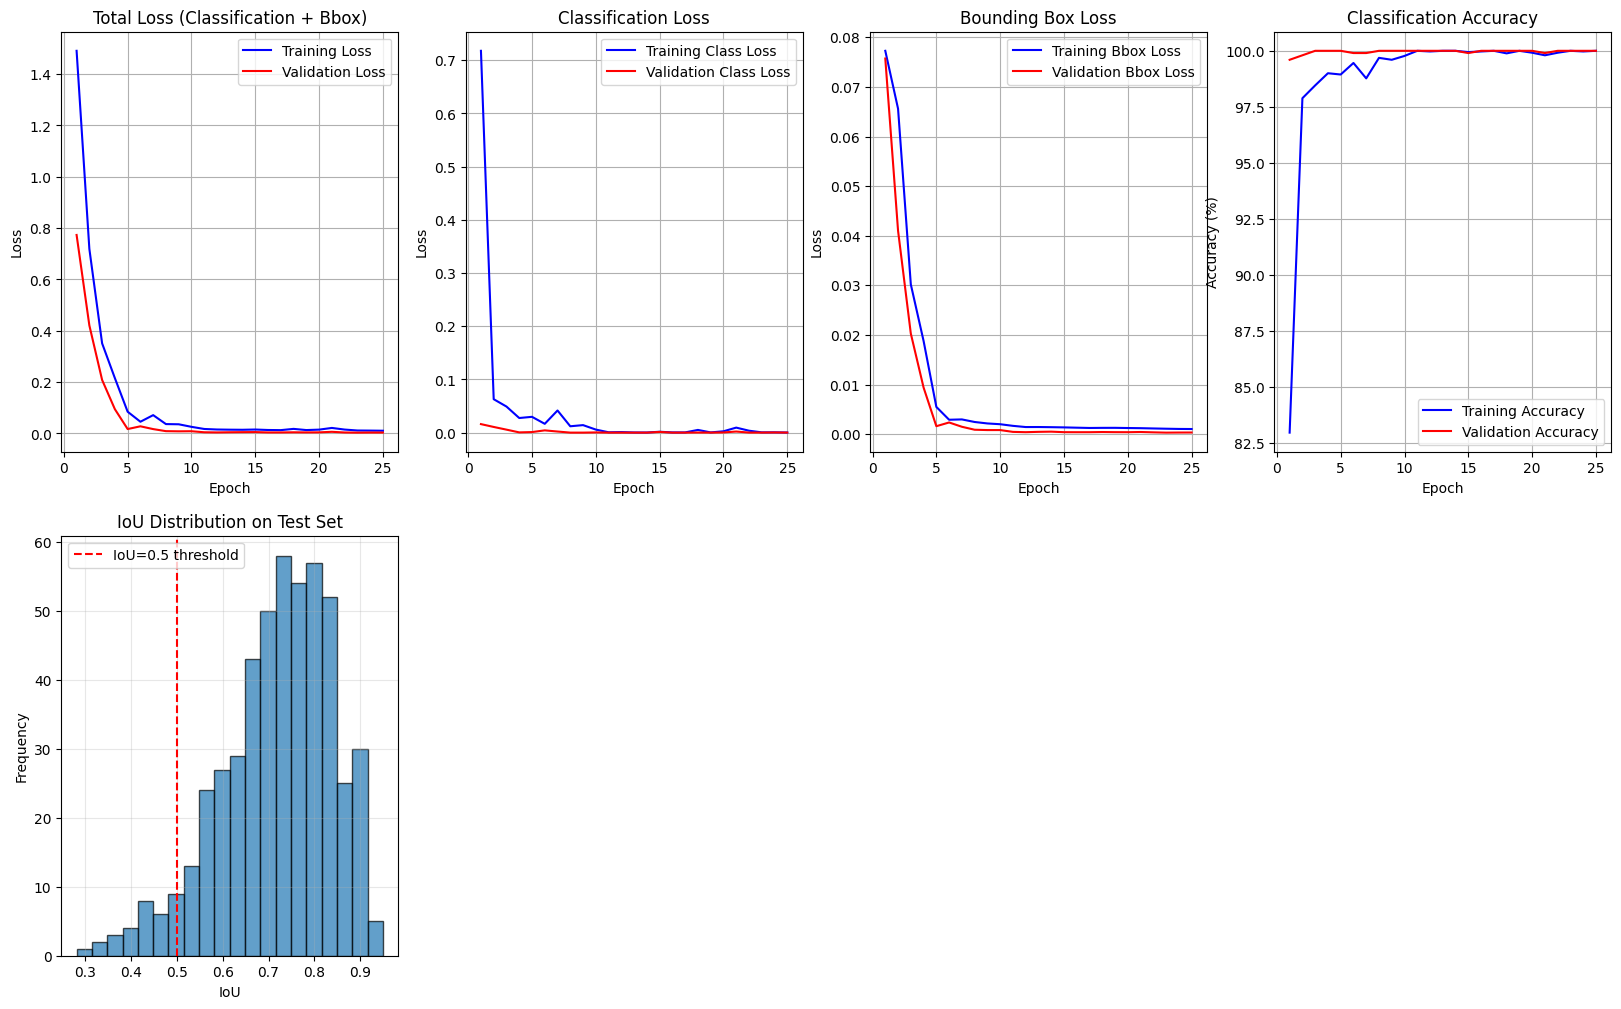

In [ ]:
# Plot training curves for object detection
plt.figure(figsize=(20, 12))

# Plot total loss curves
plt.subplot(2, 4, 1)
plt.plot(range(1, num_epochs + 1), train_losses, 'b-', label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, 'r-', label='Validation Loss')
plt.title('Total Loss (Classification + Bbox)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot classification loss curves
plt.subplot(2, 4, 2)
plt.plot(range(1, num_epochs + 1), train_class_losses, 'b-', label='Training Class Loss')
plt.plot(range(1, num_epochs + 1), val_class_losses, 'r-', label='Validation Class Loss')
plt.title('Classification Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot bbox loss curves
plt.subplot(2, 4, 3)
plt.plot(range(1, num_epochs + 1), train_bbox_losses, 'b-', label='Training Bbox Loss')
plt.plot(range(1, num_epochs + 1), val_bbox_losses, 'r-', label='Validation Bbox Loss')
plt.title('Bounding Box Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot accuracy curves
plt.subplot(2, 4, 4)
plt.plot(range(1, num_epochs + 1), train_accuracies, 'b-', label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, 'r-', label='Validation Accuracy')
plt.title('Classification Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

# Plot IoU distribution
plt.subplot(2, 4, 5)
plt.hist(ious, bins=20, alpha=0.7, edgecolor='black')
plt.title('IoU Distribution on Test Set')
plt.xlabel('IoU')
plt.ylabel('Frequency')
plt.axvline(x=0.5, color='red', linestyle='--', label='IoU=0.5 threshold')
plt.legend()
plt.grid(True, alpha=0.3)


Sample object detection predictions:


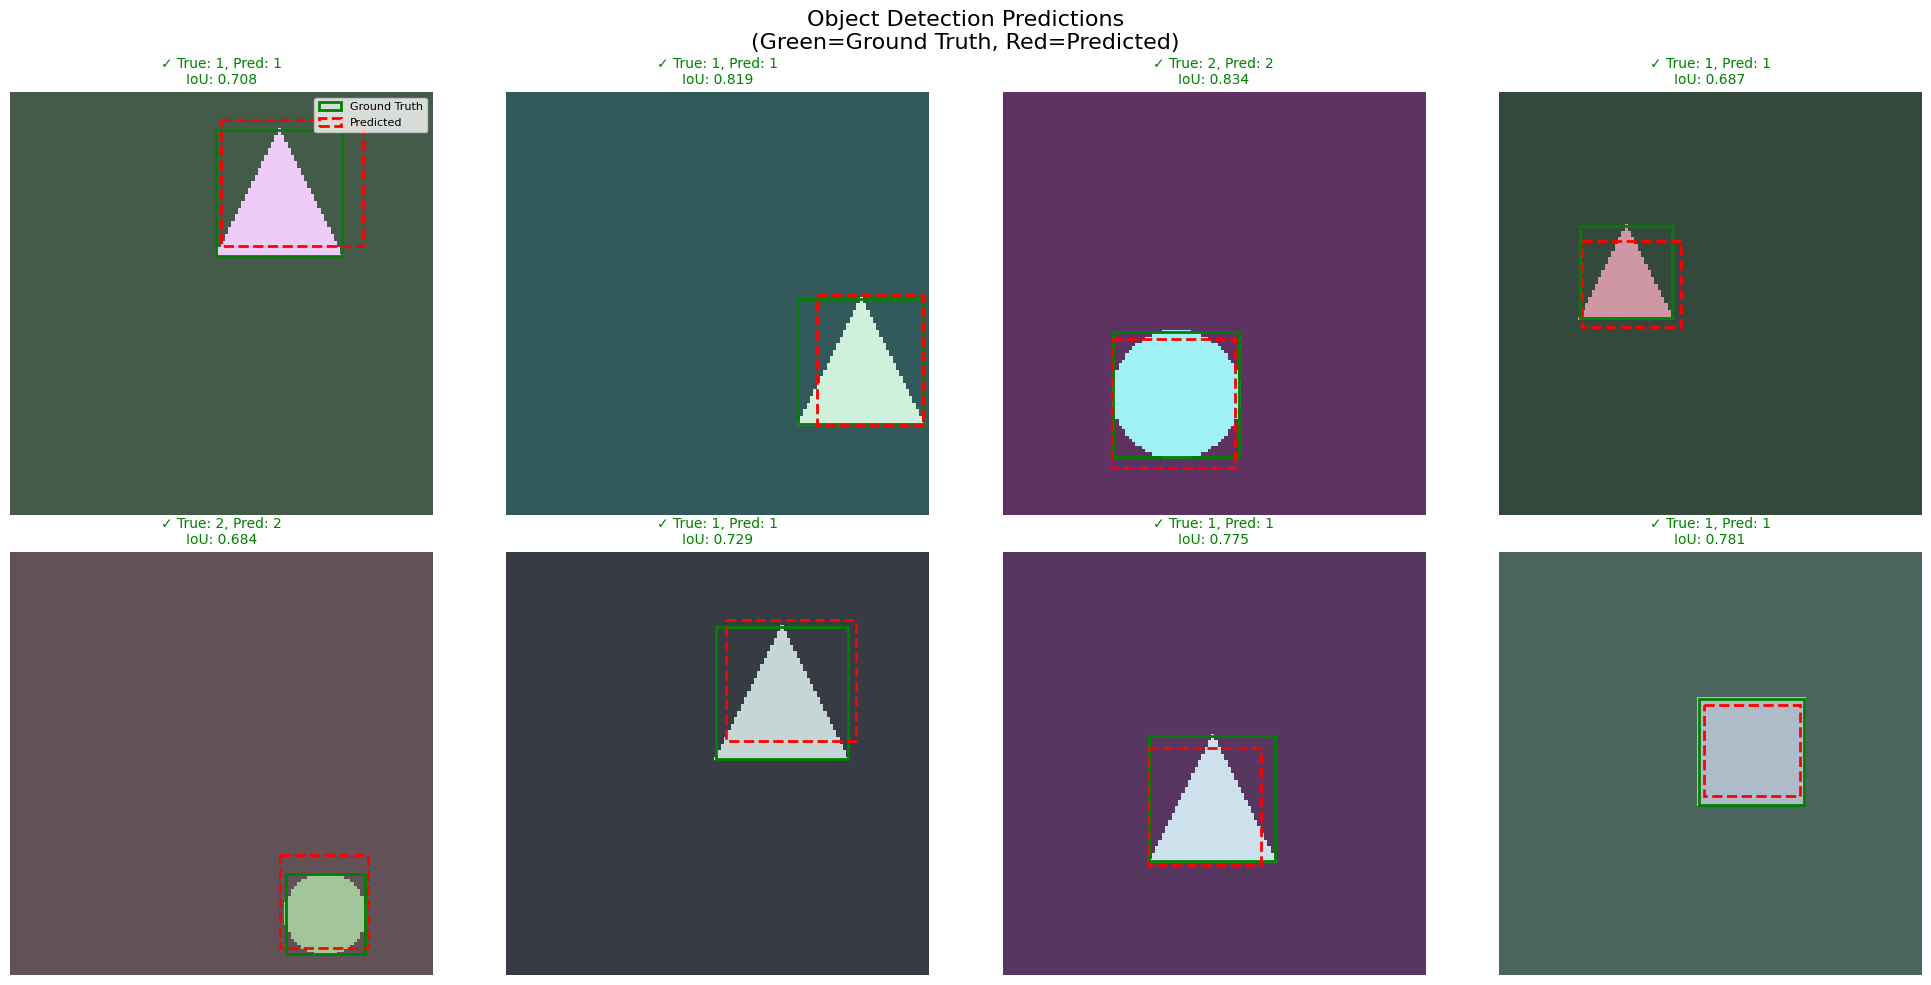

In [13]:
# Function to denormalize images for visualization
def denormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

# Show object detection predictions
def show_detection_predictions(model, test_loader, num_samples=8):
    model.eval()
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.ravel()

    with torch.no_grad():
        dataiter = iter(test_loader)
        images, true_classes, true_bboxes = next(dataiter)
        images = images.to(device)

        # Get predictions
        class_pred, bbox_pred = model(images)
        _, predicted_classes = torch.max(class_pred, 1)

        for i in range(min(num_samples, len(images))):
            # Denormalize image for display
            img = images[i].cpu().clone()
            img = denormalize(img)
            img = torch.clamp(img, 0, 1)
            img = img.permute(1, 2, 0).numpy()

            # Display image
            axes[i].imshow(img)

            # Get coordinates
            true_bbox = true_bboxes[i].cpu().numpy() * image_size
            pred_bbox = bbox_pred[i].cpu().numpy() * image_size

            true_class = true_classes[i].item()
            pred_class = predicted_classes[i].item()

            # Draw ground truth bounding box (green)
            true_x1, true_y1, true_x2, true_y2 = true_bbox
            true_rect = plt.Rectangle((true_x1, true_y1), true_x2-true_x1, true_y2-true_y1,
                                    fill=False, color='green', linewidth=2, label='Ground Truth')
            axes[i].add_patch(true_rect)

            # Draw predicted bounding box (red)
            pred_x1, pred_y1, pred_x2, pred_y2 = pred_bbox
            pred_rect = plt.Rectangle((pred_x1, pred_y1), pred_x2-pred_x1, pred_y2-pred_y1,
                                    fill=False, color='red', linewidth=2, linestyle='--', label='Predicted')
            axes[i].add_patch(pred_rect)

            # Calculate IoU for this sample
            iou = calculate_iou(pred_bbox/image_size, true_bbox/image_size)

            # Set title with class and IoU info
            class_correct = "✓" if pred_class == true_class else "✗"
            color = 'green' if pred_class == true_class and iou > 0.5 else 'red'

            title = f'{class_correct} True: {classes[true_class]}, Pred: {classes[pred_class]}\nIoU: {iou:.3f}'
            axes[i].set_title(title, color=color, fontsize=10)
            axes[i].axis('off')

            # Add legend to first subplot
            if i == 0:
                axes[i].legend(loc='upper right', fontsize=8)

    plt.suptitle('Object Detection Predictions\n(Green=Ground Truth, Red=Predicted)', fontsize=16)
    plt.tight_layout()
    plt.show()

# Show sample predictions
print("Sample object detection predictions:")
show_detection_predictions(model, test_loader)

